# Working with Maps
## Extracting Features for Traffic Crash Insights



### Jenny Turner-Trauring


# So you want to work with maps

- You might have one map for a single city
- You might have other geographical data, but you might not have a map
- You might want to combine geographical data from several data sources
- You might even want to add additional maps

For Insight Lane, we want any city to be able to use our tools, and so we use maps from OpenStreetMap as the base map

Then we can add other types of geographic features


# OpenStreetMap

OpenStreetMap is a free, open, crowdsourced map of the world

<table><tr><td><img src='osm_list.png'></td><td><img src='osm_central.png'></td></tr></table>


Lots of 3rd party services use openstreetmap

There are many more features from open street maps alone that we plan to incorporate, including (but certainly not limited to) crosswalks, stop signs, bike and pedestrian facilities, turning restrictions, dedicated turn lanes, bus stops, and school zones.



# Getting data from OpenStreetMap
- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) - read only API for accessing OpenStreetMap data
- [osmnx](https://github.com/gboeing/osmnx) is a python package that allows users to easily download OpenStreetMap data 
    - Easily download street networks for specific cities
    - Can write resulting road network to shapefiles
    - [osmnx tutorial](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)


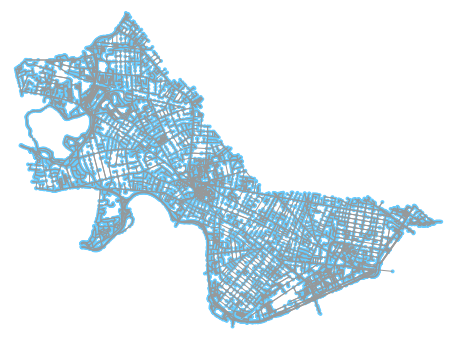

In [207]:
import osmnx as ox

def get_city(city_name, plot=False):
    G1 = ox.graph_from_place(city_name, simplify=False)
    if plot:
        ox.plot_graph(G1)

get_city('Cambridge, Massachusetts, USA', plot=True)

# If there's no city boundary defined
- We can get data within a radius, or within a polygon
- Let's look at Central Square in Cambridge, Massachusetts

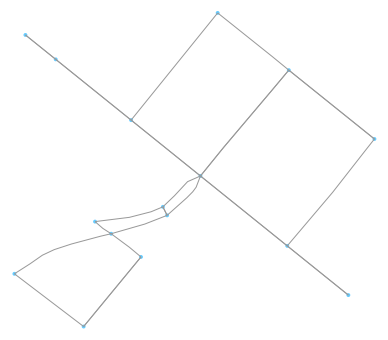

In [208]:
G2 = ox.graph_from_point((42.365572, -71.104034), distance=150, network_type='drive')
ox.plot_graph(G2)

ox.save_graph_shapefile(G2)

# Unsimplified network
- graph_from_point simplifies the network, but you might want to look at the umsimplified network
- This still removes all nodes that aren't part of the road network

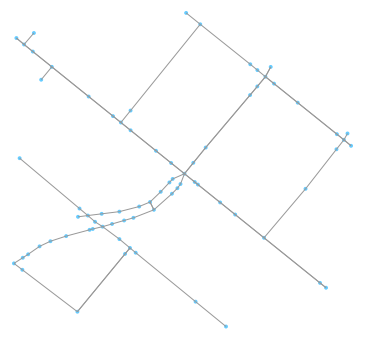

(<Figure size 628.537x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faf1b5044a8>)

In [209]:
G3 = ox.graph_from_point((42.365572, -71.104034), distance=150, network_type='drive', simplify=False)
ox.plot_graph(G3)

# Tags
- OpenStreetMap uses tags for describing features of elements
- Tags consist of key value pairs
- Some nodes have a highway tag (signals, stop signs, crosswalks)

In [210]:
import pandas
nodes, data = zip(*G1.nodes(data=True))
df_nodes = pandas.DataFrame(list(data), index=nodes)
print("{} traffic signals".format(len(df_nodes[df_nodes['highway'] == 'traffic_signals'])))
print("{} stop signs".format(len(df_nodes[df_nodes['highway'] == 'stop'])))

260 traffic signals
6 stop signs


# SIX stop signs??


- Road networks in OpenStreetMap generally are quite good
- Some other features are only as good as the crowdsourcing


Are the traffic signals any good? <br>
Let's look at traffic signals from Cambridge's Open Data portal

In [211]:
import geopandas
camb_signals = geopandas.read_file('TRAFFIC_Signals.shp')
print("{} traffic signals from Cambridge's Open Data Portal".format(len(camb_signals)))

print("{} traffic signals from OpenStreetMap".format(len(df_nodes[df_nodes['highway'] == 'traffic_signals'])))


175 traffic signals from Cambridge's Open Data Portal
260 traffic signals from OpenStreetMap


We'll look into this in a bit

# Postprocessing
- osmnx's save_graph_shapefile writes ways and nodes in ESRI shapefile format
- Can also write to osm xml file or GraphML
- We postprocess to geojson format

# Creating intersections and non-intersection segments
- Based on Azavea's [algorithm](https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/)


<img src='elements.png'  style="width: 30%; float:right;">
<ul style="width: 60%;">
    <li>Roads are OpenStreetMap ways
    <li>Intersections are remaining nodes after osmnx simplification and dropping dead ends</ul>


<img src='buffered.png'  style="width: 30%; float:right;">
<ul style="width: 60%;">
    <li>Create a 20 meter buffer around each intersection (Use shapely's buffer function)
    <li>Merge overlapping buffers (Use shapely's unary_union function)</ul>


# Resulting segments

<img src='inters.png' style="width: 30%; float: right;">
<ul style="width: 60%;">
    <li> Intersection segments</ul>



<img src='non_inters.png' style="width: 30%; float: right;">
<ul style="width: 60%;">
    <li> Non-intersection segements</ul>


In [212]:
#import fiona
#import data.util
#from shapely.geometry import LineString, Point, MultiLineString
#from shapely.ops import unary_union
#roads, inters = data.util.get_roads_and_inters('proj_example.geojson')
#data = fiona.open('proj_example.geojson')
#MultiLineString([x.geometry for x in roads])
#foo = [x for x in data]
#LineString(foo[0]['geometry']['coordinates']).intersects(Point(foo[-1]['geometry']['coordinates']))
#inters[0]['geometry'].buffer(20)
#inters[0]['geometry'].xy
#inters[0]['geometry'].intersects(roads[0].geometry)

#buff = [intersection['geometry'].buffer(20) for intersection in inters]
#buffered_intersections = unary_union(buff)
#foo = MultiLineString([x.geometry for x in roads])
#unary_union([buffered_intersections, foo])
#display(buff[0])
#display(buff[1])



# Going back to traffic signals
- Now that we have created road segments, we can dig deeper into our intersection mismatch
- Let's look at the signals from Cambridge's Open Data

In [213]:
camb_signals.head()

,ID,Location,Jurisdicti,Contact,geometry
0,1.0,Broadway & Third St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (768507.700143531 2957466.836466044)
1,5.0,Broadway & Ames Street Ext.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (767662.7496331185 2957927.718601048)
2,9.0,Broadway & Western Connecto,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (767125.0538539737 2958226.438503072)
3,13.0,Broadway & Hampshire St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (766698.3111708909 2958431.275009334)
4,17.0,Broadway & Portland St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (766416.6610007882 2958584.902387649)


In [214]:
camb_signals.crs

{'init': 'epsg:2249'}

Massachusetts Mainland projection

# Projections
- A lot of data is in EPSG:4326 aka WGS84
- EPSG:3857 (Pseudo-Mercator) projects WGS84 onto a square
- Typically store data in EPSG:4326 but display in EPGS:3857
- Useful reference [https://lyzidiamond.com/posts/4326-vs-3857](https://lyzidiamond.com/posts/4326-vs-3857)

In [215]:
def reproject(df):
    df_3857 = df.copy()
    df_3857['geometry'] = df_3857['geometry'].to_crs(epsg=3857)
    df_3857.crs = {'init' :'epsg:3857'}
    return df_3857

display(camb_signals.head(1))
camb_signals_3857 = reproject(camb_signals)
camb_signals_3857.head(1)

,ID,Location,Jurisdicti,Contact,geometry
0,1.0,Broadway & Third St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (768507.700143531 2957466.836466044)


,ID,Location,Jurisdicti,Contact,geometry
0,1.0,Broadway & Third St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913070.736672826 5215464.281262556)


# Get signals from OpenStreetMap

In [216]:
from shapely.geometry import Point

def get_osm_signals():
    osm_signals = df_nodes[df_nodes['highway'] == 'traffic_signals']

    # Turn the OpenStreetMap dataframe into a geodataframe
    geometry = [Point(xy) for xy in zip(osm_signals.x, osm_signals.y)]
    osm_signals = osm_signals.drop(['y', 'x'], axis=1)
    crs = {'init': 'epsg:4326'}
    osm_signals = geopandas.GeoDataFrame(osm_signals, crs=crs, geometry=geometry)
    osm_signals.head()
    
    osm_signals_3857 = reproject(osm_signals)
    return osm_signals_3857
    
osm_signals_3857 = get_osm_signals()
osm_signals_3857.head(1)

,osmid,highway,traffic_signals,geometry
387908358,387908358,traffic_signals,NaN,POINT (-7916969.181895554 5219304.204592618)


# Going back to traffic signals
- Now that we have created road segments, we can dig deeper into our intersection mismatch
- Let's look at the signals from Cambridge's Open Data
- Convert into EPSG:3857
- We'll treat intersections as point-based features
- Find the nearest segment to each intersection

# Read in, reproject, and index segments

In [217]:
import data.util
import fiona
import rtree

# Read in and process intersection and non-intersection segments
inter = fiona.open('inters_segments.geojson')
inter = data.util.reproject_records([x for x in inter]) 
non_inter = fiona.open('non_inters_segments.geojson')
non_inter = data.util.reproject_records([x for x in non_inter])

# Create rtree index for the segments
segments_index = rtree.index.Index()
segments = inter + non_inter

for idx, element in enumerate(segments):
    segments_index.insert(idx, element['geometry'].bounds)


In [218]:
def find_nearest(gdf, segments_dict, feature_name, key='ID'):
    near_ids = []
    for index, row in gdf.iterrows():
        row = row.to_dict()
        record_buffer_bounds = row['geometry'].buffer(20).bounds
        nearby_segments = segments_index.intersection(record_buffer_bounds)
        segment_id_with_distance = [
            # Get db index and distance to point
            (
                segments[segment_id]['properties']['id'],
                segments[segment_id]['geometry'].distance(row['geometry'])
            )
            for segment_id in nearby_segments
        ]
        if len(segment_id_with_distance):
            nearest = min(segment_id_with_distance, key=lambda tup: tup[1])
            if feature_name not in segments_dict[nearest[0]]['properties']:
                segments_dict[nearest[0]]['properties'][feature_name] = []
            segments_dict[nearest[0]]['properties'][feature_name].append(row[key])
            near_ids.append(nearest[0])
        else:
            near_ids.append(None)
    gdf = gdf.assign(near_id=near_ids)
    return gdf


In [219]:
segments_dict = {x['properties']['id']: x for x in segments}
camb = find_nearest(camb_signals_3857, segments_dict, 'camb_signals')
osm = find_nearest(osm_signals_3857, segments_dict, 'osm_signals', key='osmid')

camb_only = camb[~camb['near_id'].isin(osm['near_id'])]
osm_only = osm[~osm['near_id'].isin(camb['near_id'])]

print("{} extra signals found in Cambridge Open Data".format(camb_only.shape[0]))
print("{} extra signals found in OpenStreetMaps".format(osm_only.shape[0]))

17 extra signals found in Cambridge Open Data
41 extra signals found in OpenStreetMaps


In [220]:
camb_only_4326 = camb_only.copy()
camb_only_4326['geometry'] = camb_only['geometry'].to_crs(epsg=4326)
camb_only_4326.crs = {'init' :'epsg:4326'}
osm_only_4326 = osm_only.copy()
osm_only_4326['geometry'] = osm_only['geometry'].to_crs(epsg=4326)
osm_only_4326.crs = {'init' :'epsg:4326'}

display(camb_only.head())
print(camb_only.crs)
display(camb_signals_3857.head())
print(camb_only_4326.crs)
camb_only_4326.to_file("camb_only.geojson", driver='GeoJSON')
osm_only_4326.to_file("osm_only.geojson", driver='GeoJSON')

,ID,Location,Jurisdicti,Contact,geometry,near_id
13,49.0,Broadway & Fire Station,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7916522.050741636 5217373.961307186),00922
29,99.0,Cambridge Street & Fire Station,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7916519.002444542 5217408.777337909),001248
38,128.0,Concord Ave. & Wheeler St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7919726.698256245 5219373.506289948),1084
54,183.0,Huron Ave. & Holworthy St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7920643.077774962 5218070.865288262),825
55,191.0,Main St. & MBTA Kendall Sq.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913253.743248724 5215422.833479205),00450


{'init': 'epsg:3857'}


,ID,Location,Jurisdicti,Contact,geometry
0,1.0,Broadway & Third St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913070.736672826 5215464.281262556)
1,5.0,Broadway & Ames Street Ext.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913417.845021017 5215656.510254711)
2,9.0,Broadway & Western Connecto,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913638.728673679 5215781.078558516)
3,13.0,Broadway & Hampshire St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913814.100954205 5215866.609860722)
4,17.0,Broadway & Portland St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913929.812063706 5215930.680771952)


{'init': 'epsg:4326'}


<img src='blinking.png'>

In [226]:
ox.settings.useful_tags_node.append('traffic_signals')
get_city('Cambridge, Massachusetts, USA')
osm_signals_3857 = get_osm_signals()
osm_signals_3857.head()

ConnectionError: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Cambridge%2C+Massachusetts%2C+USA (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7faf1af221d0>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [222]:
blinkers = osm_signals_3857[osm_signals_3857['traffic_signals'] == 'blinker']
for key, value in segments_dict.items():
    for id, row in blinkers.iterrows():
        if 'osm_signals' not in value['properties']:
            continue
        if row['osmid'] in value['properties']['osm_signals']:
            value['properties']['osm_signals'].remove(row['osmid'])
            
            if len(value['properties']['osm_signals']) == 0:
                del value['properties']['osm_signals']
                print(value)
mismatch = [value for key, value in segments_dict.items() if 'osm_signals' in value['properties'] and 'camb_signals' not in value['properties']]
print("{} extra signals found in OpenStreetMaps".format(len(mismatch)))       


{'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x7faf20c190f0>, 'properties': OrderedDict([('id', 68), ('display_name', 'Allston Street and Brookline Street'), ('center_x', -71.10725163694805), ('center_y', 42.35811160451643), ('seeclickfix', 12), ('width', 12), ('cycleway_type', 0), ('oneway', 1), ('lanes', 1), ('jam', 1), ('osm_speed', 25), ('width_per_lane', 12), ('jam_percent', 0.5166744950681071), ('avg_jam_level', 4), ('parking_tickets', 13)])}
{'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x7faf20fc9b70>, 'properties': OrderedDict([('id', 86), ('display_name', 'Pleasant Street and Putnam Avenue'), ('center_x', -71.1127687913506), ('center_y', 42.36014135435531), ('seeclickfix', 13), ('width', 15), ('cycleway_type', 0), ('oneway', 1), ('lanes', 2), ('jam', 1), ('osm_speed', 25), ('width_per_lane', 12), ('jam_percent', 5.119774542038516), ('avg_jam_level', 4), ('parking_tickets', 21)])}
{'geometry': <shapely.geometry.multilinest

In [223]:
mismatch

[{'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x7faf22073fd0>,
  'properties': OrderedDict([('id', 25),
               ('display_name', 'Massachusetts Avenue and Memorial Drive'),
               ('center_x', -71.0925598570674),
               ('center_y', 42.357114602090014),
               ('seeclickfix', 6),
               ('width', 30),
               ('cycleway_type', 0),
               ('oneway', 1),
               ('lanes', 5),
               ('jam', 1),
               ('osm_speed', 0),
               ('width_per_lane', 30),
               ('jam_percent', 9.159229685298262),
               ('avg_jam_level', 3),
               ('parking_tickets', 26),
               ('osm_signals', [1986708490, 61327050])])},
 {'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x7faf227e65c0>,
  'properties': OrderedDict([('id', 49),
               ('display_name', 'Endicott Street and Memorial Drive'),
               ('center_x', -71.09647917881036),
          

In [224]:
camb_signals_4326 = camb_signals.copy()
camb_signals_4326['geometry'] = camb_signals_4326['geometry'].to_crs(epsg=4326)
camb_signals.to_file("camb_signals.geojson", driver='GeoJSON')

# What have we learned?
- OpenStreetMap may not match city data
- You may be interested in updating OpenStreetMap for your city of interest
- Good idea to sanity check your data


# Other useful info
- OpenStreetMap is internally consistent across cities
- City data might have all sorts of differening formats or projections

# We can add any point-based data
- Traffic signals
- Vision Zero portal data
- See Click Fix or 311 data
- Parking tickets
- Lots more potential data

In [225]:
import data.util
results, _ = data.util.read_segments('/home/jenny/crash-model/data/cambridge/processed/maps')
foo = [x for x in results if x.properties['parking_tickets']]
len(results)

Read in 1298 intersection, 2418 non-intersection segments


3716

# We can also add features from other maps
<img src='both_maps.png'  style="width: 30%; float:right;">
<ul style="width: 60%;">
<li>Originally we used a Boston-specific map for this project
<li>That map included speed limit, width, AADT, type of road, and more
</ul>


# Pseudocode for combining maps
- Draw a buffer around all road segments on the new map
- Add all lines that are fully within a segment's buffer to a candidate list for each segment
- Loop: for each buffer size, 5, 10, and 10 meters:
-     

# Interesting features

# Data limitations

# Equity concerns

# Insight Lane's crash model

# Contact
- jenineturner@gmail.com
- [https://github.com/j-t-t](https://github.com/j-t-t)
- [https://insightlane.org](https://insightlane.org)
- [https://github.com/Data4Democracy/crash-model](https://github.com/Data4Democracy/crash-model)